# Описание проекта
Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

# Описание данных
Таблица _rest_data:_
* _id_ — идентификатор объекта;
* _object_name_ — название объекта общественного питания;
* _chain_ — сетевой ресторан;
* _object_type_ — тип объекта общественного питания;
* _address_ — адрес;
* _number_ — количество посадочных мест.

# Содержание

[Шаг №1. Загрузка данных и подготовка к анализу](#Шаг-№1.-Загрузка-данных-и-подготовка-к-анализу)

[1  Вывод к первому шагу](#Вывод-к-первому-шагу)

[Шаг №2. Анализ данных](#Шаг-№2.-Анализ-данных)

[2  Выводы ко второму шагу](#Выводы-ко-второму-шагу)

[Шаг №3. Презентация](#Шаг-№3.-Презентация)

# Шаг №1. Загрузка данных и подготовка к анализу

In [1]:
# подключим необходимые библиотеки
import matplotlib.pyplot as plt
from io import BytesIO
from numpy import mean
import seaborn as sns
import pandas as pd
import collections
import requests
import string
import json

In [2]:
# открываем файл
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
# открываем файл с данными по районам, скаченный из интернета
spreadsheet_id = '1y0RrlTCf-nnKFA4eGxYDbSI7xOU7Zfk8SR2Gu-SUuGs'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
district = pd.read_csv(BytesIO(r.content), sep=',')

In [4]:
district.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [5]:
district.isnull().sum()

streetname    0
areaid        0
okrug         0
area          0
dtype: int64

Пропуски в датасете с _районами_ отсутствуют.

In [6]:
district.duplicated().sum()

8

In [7]:
district = district.drop_duplicates().reset_index(drop = True)

In [8]:
district['streetname'].duplicated().sum()

786

In [9]:
district = district[district['streetname'].duplicated() == False]

Дубликаты в датасете с _районами_ удалены.

In [10]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [11]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Все данные необходимых типов, т. е. ничего преобразовывать в другой тип не надо.

In [12]:
rest_data.isnull().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Пропуски в данных отсутствуют.

In [13]:
rest_data.duplicated().sum()

0

Дубликаты также отсутствуют.

In [14]:
rest_data['id'].duplicated().sum()

0

In [15]:
rest_data.duplicated(subset = ['object_name', 'chain', 'object_type', 'address', 'number']).sum()

82

In [16]:
print('{:.2%}'.format(rest_data.duplicated(subset = ['object_name', 'chain', 'object_type', 'address', 'number']).sum() / len(rest_data)))

0.53%


Проверка всех столбцов, кроме столбца _id_ выявила _дубликатоты,_ однако их можно не трогать, т. к. это могут быть заведения, которые встречаются несколько раз на одном адресе, например в крупных торговых центрах, может быть несколько заведений одной сети с одним адресом. К тому же таких заведений 0,53%, что точно явно не отразиться на результатах исследования.

## Вывод к первому шагу

Был загружен исходный датасет, данные были необходимых типов, без пропусков и дубликатов. Также был найден датасет в интернете, с данными соответстрия улицы города и района, в этом датасете отсутствовали пропуски, дубликаты удалены.

# Шаг №2. Анализ данных

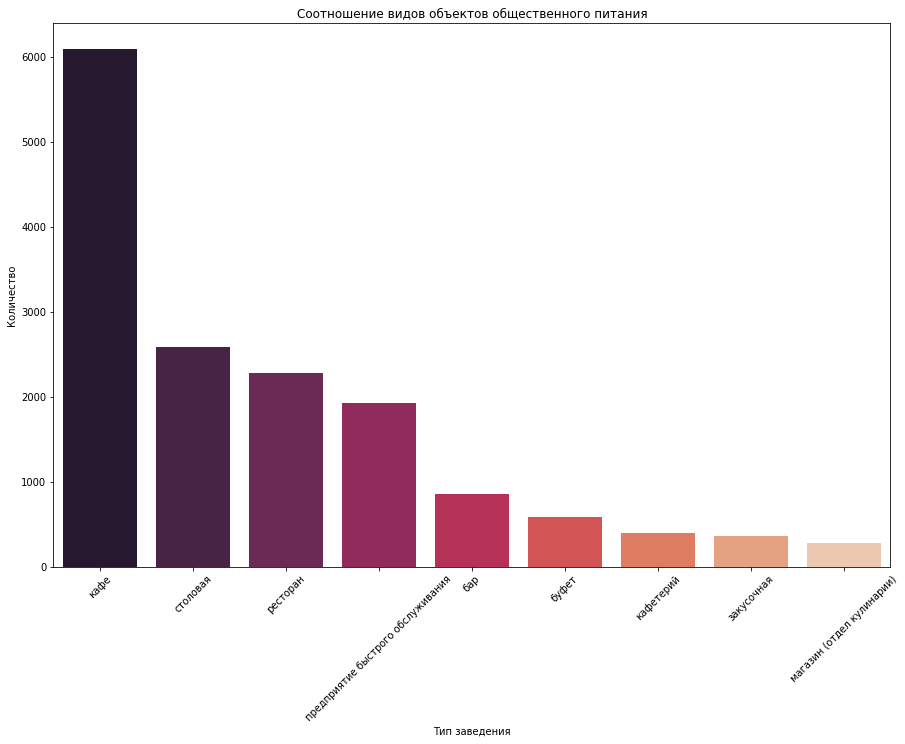

In [17]:
plt.figure(figsize=(15,10))
sns.countplot(data = rest_data, x = 'object_type', palette = 'rocket', order=rest_data['object_type'].value_counts().index)
plt.title('Cоотношение видов объектов общественного питания')
plt.xlabel('Тип заведения')
plt.xticks(rotation = 45)
plt.ylabel('Количество')
plt.show()

Исходя из графика _соотношения видов объектов общественного питания_ делаем вывод что самыми популярными являются **кафе**, они встречаются более чем _в два рача чаще_ остальных заведений. Далее идут _столовые_ и _рестораны_. Самыми непопулярными являются _магазины с отделами кулинарии,_ _закусочные_ и _кафетерии_.

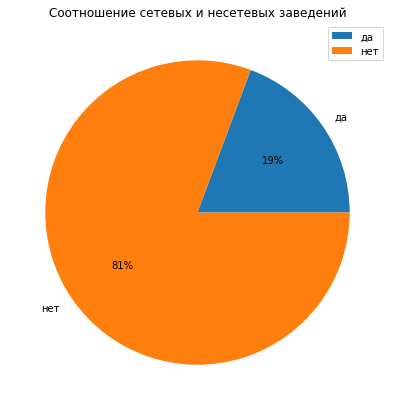

In [18]:
rest_data.groupby('chain').agg({'chain' : 'count'}).plot(y = 'chain', kind = 'pie', autopct='%1.0f%%', figsize=(15,7))

plt.title('Cоотношение сетевых и несетевых заведений')
plt.ylabel('')
plt.show()

При анализе сетевых заведений делаем вывод, что большинство заведений являются **не сетевыми (81%),** сетевыми являются - _19% заведений._

In [19]:
rest_data_chain = rest_data.query('chain == "да"')

In [20]:
object_type_list = rest_data['object_type'].unique()
type_of_share = {}

for object_type in object_type_list:
    len_rest_data = len(rest_data[rest_data['object_type'] == object_type])
    len_rest_data_chain = len(rest_data_chain[rest_data_chain['object_type'] == object_type])
    type_of_share[object_type] = len_rest_data_chain / len_rest_data

sorted_type_of_share = sorted(type_of_share.items(), key = lambda kv: kv[1])

sorted_type_of_share = collections.OrderedDict(sorted_type_of_share)

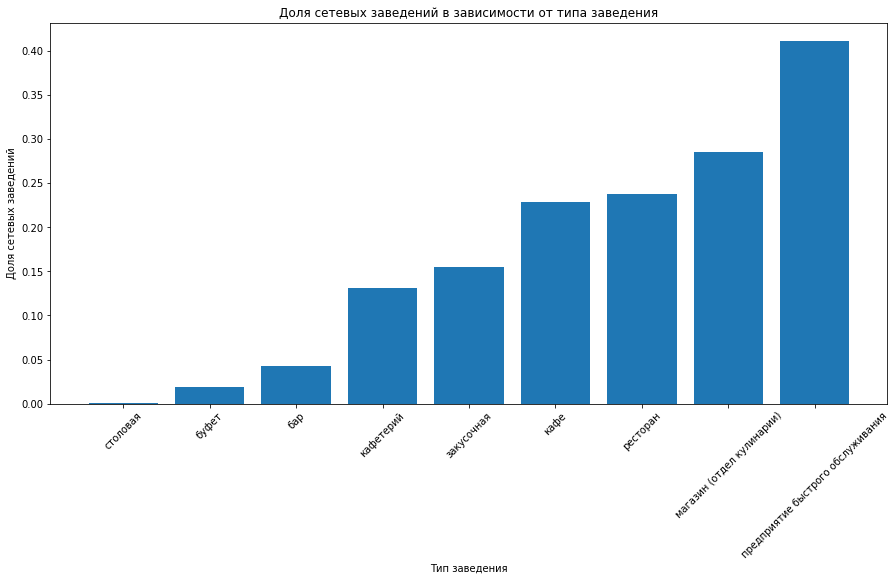

In [21]:
plt.figure(figsize=(15,7))
plt.bar(sorted_type_of_share.keys(), sorted_type_of_share.values())
plt.title('Доля сетевых заведений в зависимости от типа заведения')
plt.xlabel('Тип заведения')
plt.ylabel('Доля сетевых заведений')
plt.xticks(rotation = 45)
plt.show()

Исходя из графика _доли сетевых заведений в зависимости от типа заведения_ делаем вывод что самыми популярными среди сетевых заведений являются **предприятия быстрого обслуживания**, далее идут _магазины (отдел кулинарии),_ _рестораны_ и _кафе_. Самыми непопулярными в сетевом плане являются _столовые, буфеты и бары._

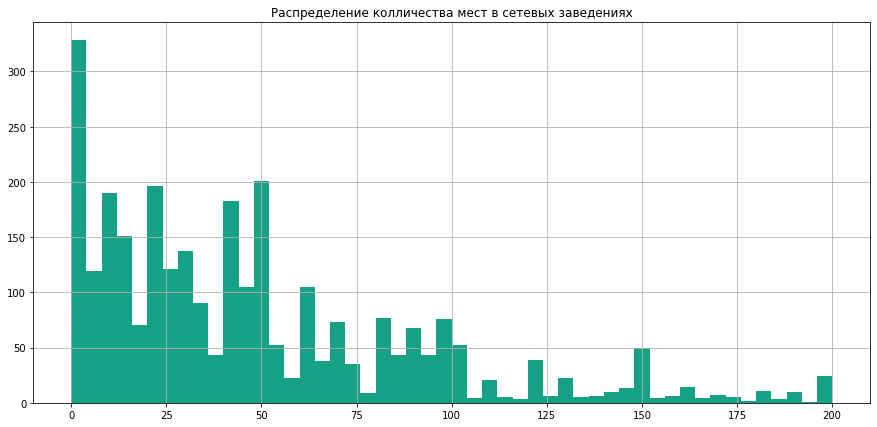

In [22]:
rest_data_chain['number'].hist(bins = 50, range = (0, 200), color = '#16A085', figsize=(15,7))
plt.title('Распределение колличества мест в сетевых заведениях')
plt.show()

Исходя из гистограммы _распределения колличества мест в сетевых заведениях_ делаем вывод, что большинсво мест в заведениях лежит в диапазоне **до 50 мест**, чуть меньше заведений с кооличеством мест _от 50 до 100_. 

In [23]:
establishments_places = rest_data_chain.groupby('number').agg({'object_name' : 'count', 'number' : 'min'})

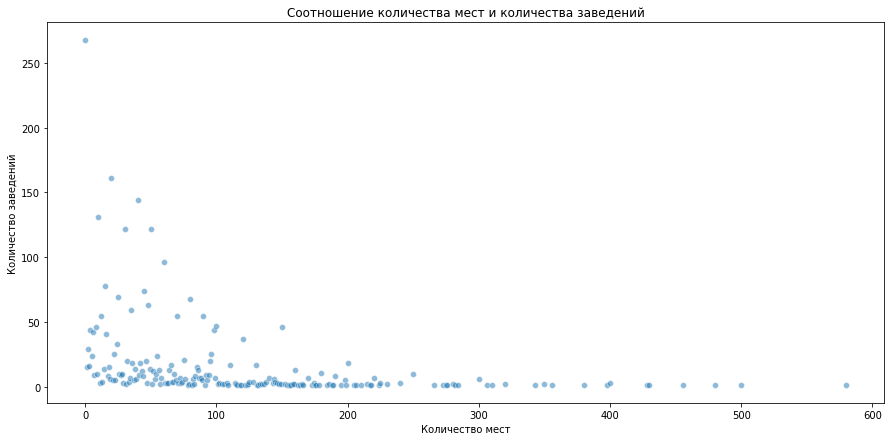

In [24]:
plt.figure(figsize=(15,7))
sns.scatterplot(data = establishments_places, x = 'number', y = 'object_name', alpha = .5)
plt.title('Cоотношение количества мест и количества заведений')
plt.xlabel('Количество мест')
plt.ylabel('Количество заведений')
plt.show()

Исходя из графика _соотношения количества мест и количества заведений_ делаем вывод что чаще всего в сетевых заведениях встречается **небольшое число заведений (до 25) с небольшим количеством мест (до 100)**. Также встречаются заведения с количеством мест от 100 до 250, но реже, чем заведения с количеством мест меньше 100.

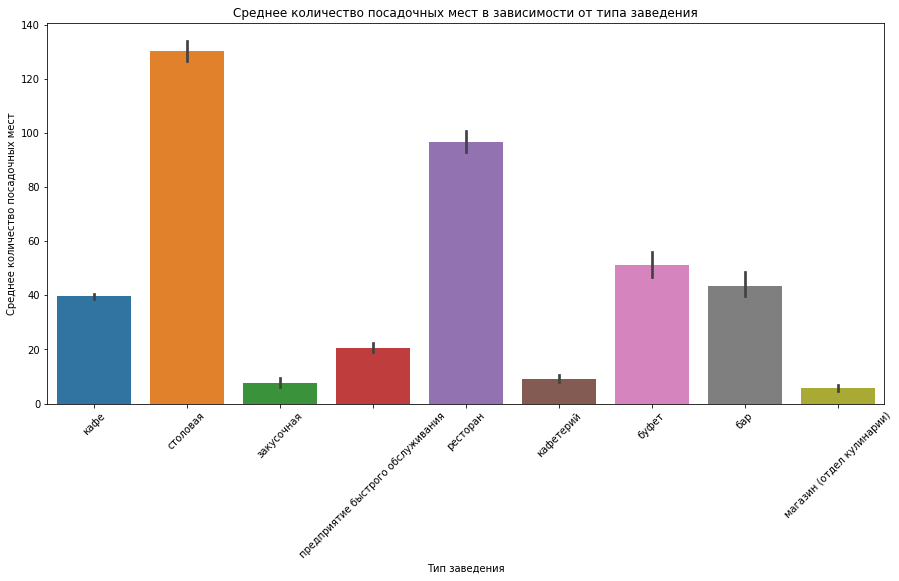

In [25]:
plt.figure(figsize=(15,7))
sns.barplot(x = 'object_type', y = 'number', data = rest_data, estimator = mean)
plt.title('Среднее количество посадочных мест в зависимости от типа заведения')
plt.xlabel('Тип заведения')
plt.ylabel('Среднее количество посадочных мест')
plt.xticks(rotation = 45)
plt.show()

Исходя из графика _среднего количества посадочных мест в зависимости от типа заведения_ делаем вывод что в среднем больше всего посадочных мест в **столовых**, далее идут _рестораны_ и _буфеты_. Меньше всего в среднем мест в _магазинах с отделом кулинарии,_ _закусочных_ и _кафетериях._

In [26]:
# выделим в отдельный столбец информацию об улице
list_excess = (['город Московский','поселение "Мосрентген"','поселение Московский','поселение Михайлово-Ярцевское',
                'поселение Марушкинское','город Троицк','поселение Сосенское','город Зеленоград'])

def street_search(row):
    if row['address'].split(',')[0].strip() == 'город Москва' and row['address'].split(',')[1].strip() not in list_excess:
        return row['address'].split(',')[1].strip()
    elif row['address'].split(',')[1].strip() in list_excess:
        return row['address'].split(',')[2].strip()
    else:
        return row['address'].split(',')[0].strip()

a = 0

rest_data['street'] = rest_data.apply(street_search, axis = 1)

In [27]:
street_count = rest_data.groupby('street').agg({'id' : 'count'})
street_count.columns = ['count_object']
rest_data = pd.merge(rest_data, street_count, on = 'street')

district = district.drop(['areaid', 'okrug'], 1)
district.columns = ['street', 'area']

rest_data = pd.merge(rest_data, district, on = 'street', how = 'left')

In [28]:
street_top10 = rest_data.groupby('street').agg({'object_name' : 'count', 'area' : 'min'}).sort_values(by = 'object_name', ascending = False).head(10)

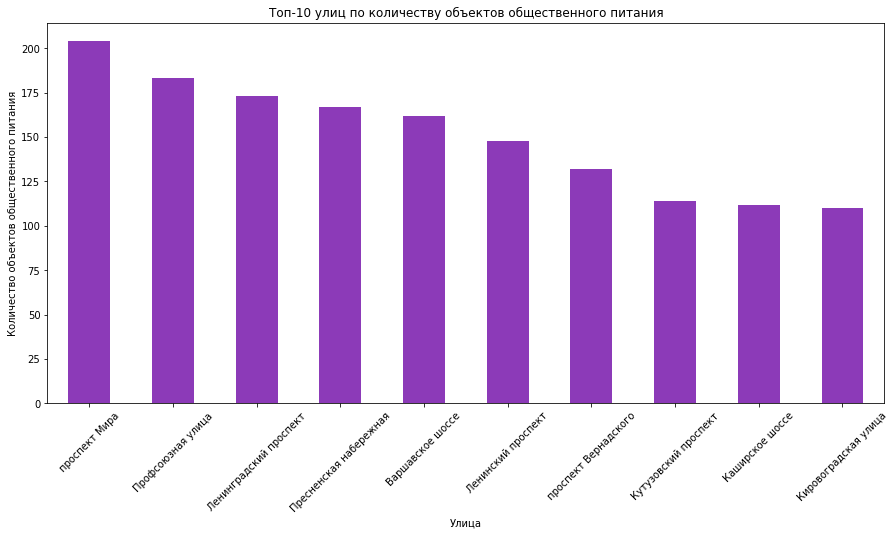

In [29]:
street_top10.plot(kind = 'bar', color = '#8C3AB8', legend = False, figsize=(15,7))
plt.title('Топ-10 улиц по количеству объектов общественного питания')
plt.xlabel('Улица')
plt.ylabel('Количество объектов общественного питания')
plt.xticks(rotation = 45)
plt.show()

Исходя из графика _топ-10 улиц по количеству объектов общественного питания_ наиболее популярными улицами для объектов общественного питания являются:

* проспект Мира
* Профсоюзная улица
* Ленинградский проспект
* Пресненская набережная
* Варшавское шоссе	
* Ленинский проспект
* проспект Вернадского
* Кутузовский проспект
* Каширское шоссе
* Кировоградская улица

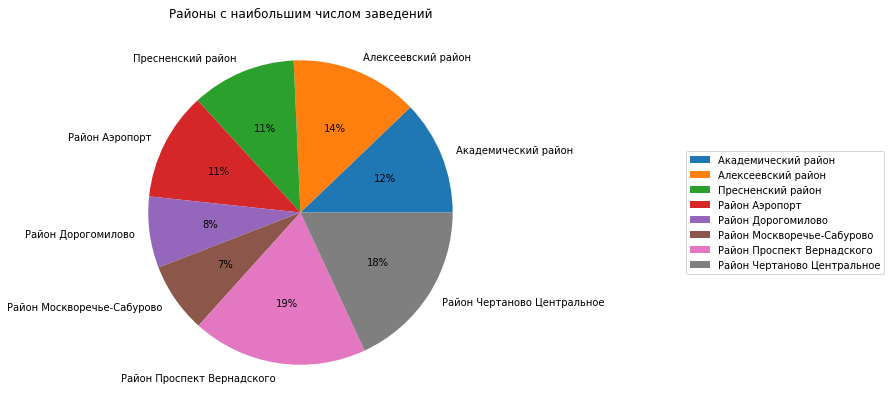

In [30]:
street_top10.groupby('area').agg({'object_name' : 'sum'}).plot(y = 'object_name', kind = 'pie', autopct='%1.0f%%', figsize=(15,7))
plt.title('Районы с наибольшим числом заведений')
plt.legend(loc = 'center left', bbox_to_anchor=(1.5, 0.5))
plt.ylabel('')
plt.show()

Исходя из диаграммы _районов с наибольшим числом заведений_ наиболее популярными являются:
* Район Проспект Вернадского
* Район Чертаново Центральное
* Алексеевский район
* Академический район
* Район Аэропорт
* Пресненский район
* Район Дорогомилово
* Район Москворечье-Сабурово

In [31]:
street_one_object = rest_data.query('count_object == 1')

In [32]:
print('Всего улиц с одним объектом общественного питания:', len(street_one_object))

Всего улиц с одним объектом общественного питания: 656


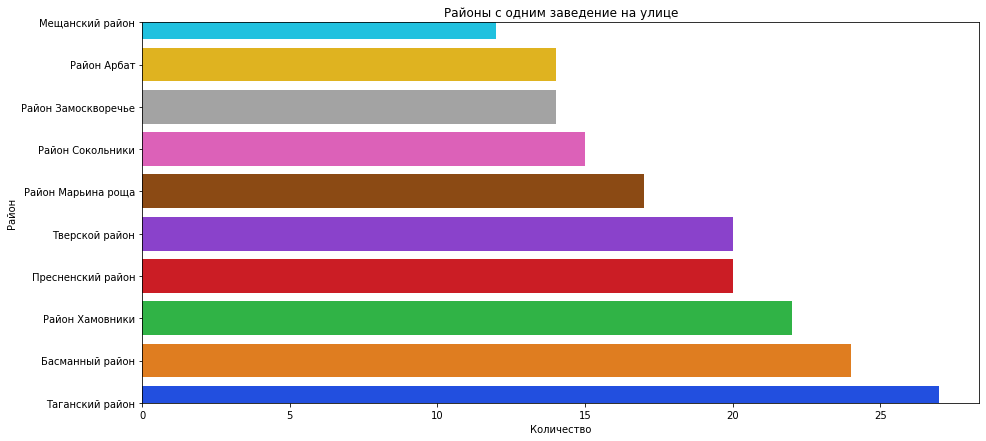

In [33]:
plt.figure(figsize=(15,7))
sns.countplot(data = street_one_object, y = 'area', palette = 'bright', order = street_one_object['area'].value_counts().index)
plt.title('Районы с одним заведение на улице')
plt.xlabel('Количество')
plt.ylabel('Район')
plt.ylim(0, 9)
plt.show()

Исходя из графика _районнов с одним заведением на улице_ больше всего улиц с одним заведением в районах:
* Таганский район
* Басманный район
* Район Хамовники
* Тверской район
* Пресненский район

In [34]:
street_list = rest_data.groupby('street').agg({'object_name' : 'count', 'street' : 'min'}).sort_values(by = 'object_name', ascending = False).head(10)['street'].values

In [35]:
street_top10_number = rest_data.query('street in @street_list')

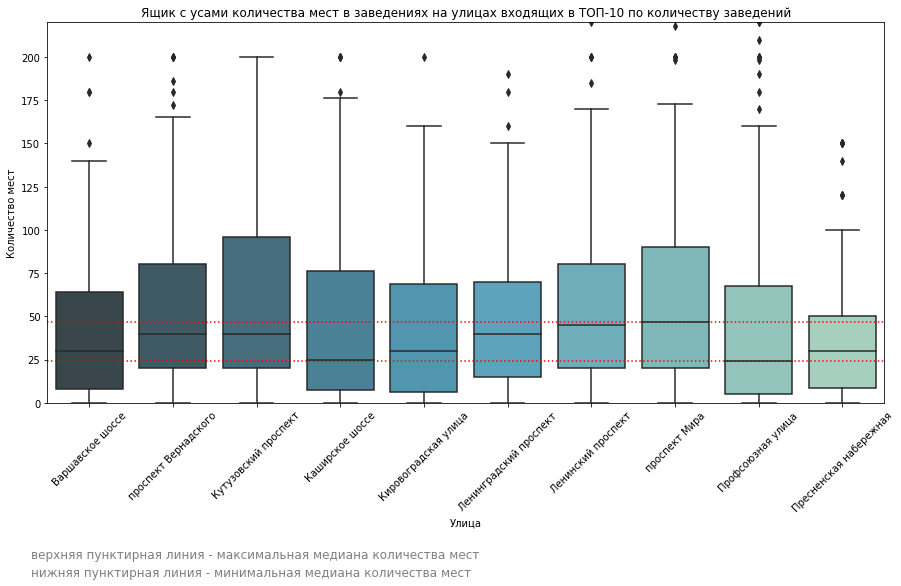

In [36]:
plt.figure(figsize = (15, 7))
sns.boxplot(data = street_top10_number, x = 'street', y = 'number', palette = 'GnBu_d')
plt.title('Ящик с усами количества мест в заведениях на улицах входящих в ТОП-10 по количеству заведений')
plt.xlabel('Улица')
plt.ylabel('Количество мест')
plt.ylim(0, 220)
plt.xticks(rotation = 45)
plt.text(-0.7, -90, 'верхняя пунктирная линия - максимальная медиана количества мест', fontsize = 12, color = 'gray')
plt.text(-0.7, -100, 'нижняя пунктирная линия - минимальная медиана количества мест', fontsize = 12, color = 'gray')
plt.axhline(y = street_top10_number.groupby('street').agg({'number' : 'median'})['number'].min(), color = 'red', linestyle = 'dotted') 
plt.axhline(y = street_top10_number.groupby('street').agg({'number' : 'median'})['number'].max(), color = 'red', linestyle = 'dotted') 
plt.show()

Исходя из  _«ящика с усами» количества мест в заведениях на улицах входящих в ТОП-10 по количеству заведений_ можно сделать вывод, что колличество мест лежит в диапазоне от 7 до 100, однако в **среднем** колличество мест коллеблется **от 24 до 47**.

## Выводы ко второму шагу

Исходя из графика _соотношения видов объектов общественного питания_ делаем вывод что самыми популярными являются **кафе**, они встречаются более чем _в два рача чаще_ остальных заведений. Далее идут _столовые_ и _рестораны_. Самыми непопулярными являются _магазины с отделами кулинарии,_ _закусочные_ и _кафетерии_.

При анализе сетевых заведений делаем вывод, что большинство заведений являются **не сетевыми (81%),** сетевыми являются - _19% заведений._

Исходя из графика _доли сетевых заведений в зависимости от типа заведения_ делаем вывод что самыми популярными среди сетевых заведений являются **предприятия быстрого обслуживания**, далее идут _магазины (отдел кулинарии),_ _рестораны_ и _кафе_. Самыми непопулярными с сетевом плане являются _столовые, буфеты и бары._

Исходя из _гистограммы распределения колличества мест в сетевых заведениях_ делаем вывод, что большинсво мест в заведениях лежит в диапазоне **до 50 мест**, чуть меньше заведений с кооличеством мест _от 50 до 100._

Исходя из графика _соотношения количества мест и количества заведений_ делаем вывод что чаще всего в сетевых заведениях встречается **небольшое число заведений (до 25) с небольшим количеством мест (до 100)**. Также встречаются заведения с количеством мест от 100 до 250, но реже, чем заведения с количеством мест меньше 100.

Исходя из _графика среднего количества посадочных мест в зависимости от типа заведения_ делаем вывод что в среднем больше всего посадочных мест в **столовых**, далее идут _рестораны_ и _буфеты_. Меньше всего в среднем мест в _магазинах с отделом кулинарии,_ _закусочных_ и _кафетериях_.

Исходя из _графика топ-10 улиц по количеству объектов общественного питания_ наиболее популярными улицами для объектов общественного питания являются:

* проспект Мира
* Профсоюзная улица
* Ленинградский проспект
* Пресненская набережная
* Варшавское шоссе	
* Ленинский проспект
* проспект Вернадского
* Кутузовский проспект
* Каширское шоссе
* Кировоградская улица

Исходя из _диаграммы районов с наибольшим числом заведений_ наиболее популярными являются:

* Район Проспект Вернадского
* Район Чертаново Центральное
* Алексеевский район
* Академический район
* Район Аэропорт
* Пресненский район
* Район Дорогомилово
* Район Москворечье-Сабурово

Всего улиц с _одним_ объектом общественного питания: **656**.

Исходя из _графика районнов с одним заведением на улице_ больше всего улиц с одним заведением в районах:

* Таганский район
* Басманный район
* Район Хамовники
* Тверской район
* Пресненский район

Исходя из _«ящика с усами» количества мест в заведениях на улицах входящих в ТОП-10 по количеству заведений_ можно сделать вывод, что колличество мест лежит в диапазоне _от 7 до 100,_ однако в среднем колличество мест коллеблется **от 24 до 47**.

**ИТОГ**

На основании проведённого иследования можно сделать сдедующую рекомендацию.

При выборе местоположения ресторана стоит ориентироваться на следующие улицы:
* проспект Мира
* Профсоюзная улица
* Ленинградский проспект
* Пресненская набережная
* Варшавское шоссе	

При выборе заведения стоит ориентироваться на следующие типы заведения:
* кафе
* столовая
* ресторан

Есть планируется переход на сетевое заведение стоит ориентироваться на следующие типы заведения:
* предприятие быстрого обслуживания
* магазин (отдел кулинарии)
* ресторан
* кафе

При выборе количества посадочных мест рекомендуется ориентироваться на **25 - 50** посадочных мест.

При успешном запуске первого заведения _рекомендуется_ **развивать сеть** и открывать ещё заведения под одним названием.

# Шаг №3. Презентация

[Презентация](https://disk.yandex.by/i/yd8-uPtnkpQV2g)